In [6]:
def get_gamma(eta,lambda_max=25):
    gamma=1-(eta/lambda_max)
    return gamma


Plot saved as Combined_Analysis_Unified.png


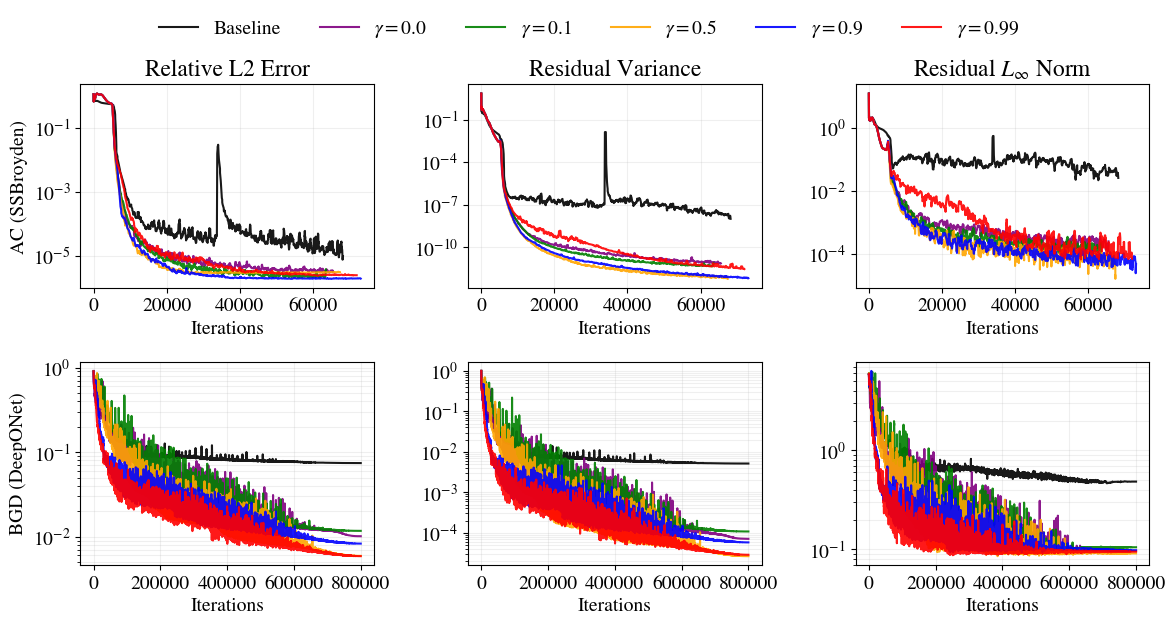

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob

# --- Global style settings ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

class CombinedAnalysis:
    def __init__(self):
        # Shared Smoothing Setting
        self.smooth_window = 5

        # --- AC Configuration ---
        self.ac_base_dir = "/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/PINN/Sensitivity_Analysis/AC"
        self.ac_baseline_file = "results_linear.npz"
        self.ac_keys = ['baseline', '0.0', '0.1', '0.5', '0.9', '0.99']
        
        # Unified Colors/Labels Map (Used for both rows)
        self.unified_map = {
            'baseline': {'label': 'Baseline',         'color': 'k',      'order': 0},
            '0.0':      {'label': r'$\gamma = 0.0$',  'color': 'purple', 'order': 1},
            '0.1':      {'label': r'$\gamma = 0.1$',  'color': 'green',  'order': 2},
            '0.5':      {'label': r'$\gamma = 0.5$',  'color': 'orange', 'order': 3},
            '0.9':      {'label': r'$\gamma = 0.9$',  'color': 'blue',   'order': 4}, 
            '0.99':     {'label': r'$\gamma = 0.99$', 'color': 'red',    'order': 5}
        }

        # --- BGD Configuration ---
        self.bgd_results_dir = "/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning/bubble_don/vrba_sensitivity/results"
        self.bgd_batch_scaler = 80
        self.bgd_target_etas = [15.0, 13.5, 7.5, 1.0, 0.1]
        
        # Map BGD Etas to the Unified Keys
        self.bgd_key_map = {
            'Vanilla': 'baseline',
            15.0: '0.0',
            13.5: '0.1',
            7.5:  '0.5',
            1.0:  '0.9',
            0.1:  '0.99'
        }

    # --- SHARED SMOOTHING ---
    def smooth_signal(self, data, window_size):
        if data is None or len(data) == 0: return data
        if len(data) < window_size: return data
        window_size = int(window_size)
        kernel = np.ones(window_size) / float(window_size)
        smoothed_valid = np.convolve(data, kernel, mode='valid')
        out = np.copy(data)
        start_idx = (window_size - 1) // 2
        out[start_idx:start_idx + len(smoothed_valid)] = smoothed_valid
        return out

    # --- AC DATA LOADING ---
    def load_ac_data(self, key):
        if key == 'baseline':
            filename = os.path.join(self.ac_base_dir, self.ac_baseline_file)
        else:
            filename = os.path.join(self.ac_base_dir, f'results_quadratic_{key}.npz')
        
        if not os.path.exists(filename): return None
        try:
            data = np.load(filename)
        except Exception:
            return None
            
        h_l2 = data.get('error_history', data.get('error_hist', None))
        h_linf = data.get('linf_history', None)
        h_var = data.get('var_history', None)
        
        keys = list(data.keys())
        if 'all_its' in keys: iterations = data['all_its']
        else: iterations = np.arange(len(h_l2)) if h_l2 is not None else None

        return {'key': key, 'hist_l2': h_l2, 'hist_linf': h_linf, 'hist_var': h_var, 'iterations': iterations}

    # --- BGD DATA LOADING ---
    def get_bgd_file_info(self, filename):
        name = os.path.basename(filename).replace(".npz", "")
        if "Vanilla" in name: return 'baseline'
        parts = name.split('_')
        try:
            val = float(parts[-1])
            if val in self.bgd_target_etas: return self.bgd_key_map[val]
        except ValueError: pass
        return None

    def run(self):
        # Create 2x3 Plot
        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        
        col_titles = ["Relative L2 Error", "Residual Variance", r"Residual $L_{\infty}$ Norm"]

        # ==========================================
        # ROW 1: AC (SSBroyden)
        # ==========================================
        for key in self.ac_keys:
            pkg = self.load_ac_data(key)
            if pkg is None: continue
            
            # Use unified style
            style = self.unified_map[key]
            its = pkg['iterations']

            if its is not None:
                # Apply Smoothing to AC data
                l2_smooth = self.smooth_signal(pkg['hist_l2'], self.smooth_window)
                var_smooth = self.smooth_signal(pkg['hist_var'], self.smooth_window)
                linf_smooth = self.smooth_signal(pkg['hist_linf'], self.smooth_window)

                if l2_smooth is not None:
                    axes[0, 0].plot(its, l2_smooth, label=style['label'], color=style['color'], alpha=0.9)
                if var_smooth is not None:
                    min_l = min(len(its), len(var_smooth))
                    axes[0, 1].plot(its[:min_l], var_smooth[:min_l], color=style['color'], alpha=0.9)
                if linf_smooth is not None:
                    min_l = min(len(its), len(linf_smooth))
                    axes[0, 2].plot(its[:min_l], linf_smooth[:min_l], color=style['color'], alpha=0.9)

        # ==========================================
        # ROW 2: BGD (DeepONet)
        # ==========================================
        files = glob.glob(os.path.join(self.bgd_results_dir, "metrics_*.npz"))
        valid_files = []
        for f in files:
            unified_key = self.get_bgd_file_info(f)
            if unified_key is not None: 
                valid_files.append((unified_key, f))
        
        # Sort by order defined in unified_map
        valid_files.sort(key=lambda x: self.unified_map[x[0]]['order'])

        for key, filepath in valid_files:
            try:
                data = np.load(filepath)
                val_loss = data['val_loss']
                var_residual = data['var_residual']
                linf_residual = data['L_infty_residual']
                iterations = data['epochs'] * self.bgd_batch_scaler
                
                style = self.unified_map[key]
                
                # Apply Smoothing to BGD data
                l2_smooth = self.smooth_signal(val_loss, self.smooth_window)
                var_smooth = self.smooth_signal(var_residual, self.smooth_window)
                linf_smooth = self.smooth_signal(linf_residual, self.smooth_window)

                # Plot (No Label here, we use global legend)
                axes[1, 0].plot(iterations, l2_smooth, color=style['color'], alpha=0.9)
                axes[1, 1].plot(iterations, var_smooth, color=style['color'], alpha=0.9)
                axes[1, 2].plot(iterations, linf_smooth, color=style['color'], alpha=0.9)
            except Exception as e:
                print(f"[BGD] Error reading {filepath}: {e}")

        # ==========================================
        # FORMATTING & GLOBAL LEGEND
        # ==========================================
        for row in range(2):
            for col in range(3):
                ax = axes[row, col]
                ax.set_yscale('log')
                ax.grid(True, which="both", alpha=0.2)
                ax.set_xlabel("Iterations")
                
                if row == 0:
                    ax.set_title(col_titles[col])

        # Y-Labels on left-most plots
        axes[0, 0].set_ylabel("AC (SSBroyden)")
        axes[1, 0].set_ylabel("BGD (DeepONet)")

        # Create Single Global Legend above the plots
        handles, labels = axes[0, 0].get_legend_handles_labels()
        # Increased bbox_to_anchor y from 1.02 to 1.06 to move it up
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.06), 
                   ncol=6, frameon=False, fontsize=14)

        plt.tight_layout()
        plt.savefig("Combined_Analysis_Unified.png", dpi=300, bbox_inches='tight')
        print("Plot saved as Combined_Analysis_Unified.png")
        plt.show()

if __name__ == "__main__":
    analysis = CombinedAnalysis()
    analysis.run()

Plot saved as Combined_Analysis_Unified.png


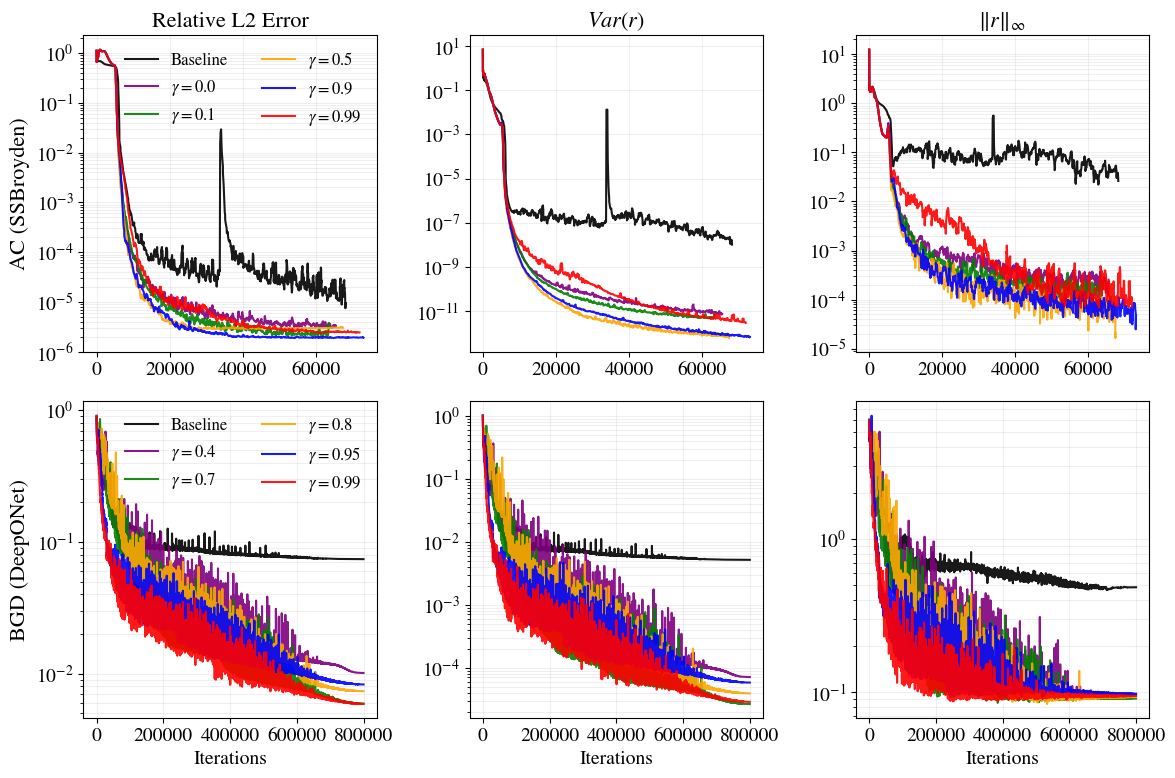

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob

# --- Global style settings ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

class CombinedAnalysis:
    def __init__(self):
        # Shared Smoothing Setting
        self.smooth_window = 5

        # ==========================================
        # UNIFIED COLOR PALETTE
        # ==========================================
        self.color_palette = ['k', 'purple', 'green', 'orange', 'blue', 'red']

        # ==========================================
        # AC CONFIGURATION (Row 1)
        # ==========================================
        self.ac_base_dir = "/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/PINN/Sensitivity_Analysis/AC"
        self.ac_baseline_file = "results_linear.npz"
        self.ac_keys = ['baseline', '0.0', '0.1', '0.5', '0.9', '0.99']
        
        self.ac_styles = {
            'baseline': {'label': 'Baseline',         'c_idx': 0},
            '0.0':      {'label': r'$\gamma = 0.0$',  'c_idx': 1},
            '0.1':      {'label': r'$\gamma = 0.1$',  'c_idx': 2},
            '0.5':      {'label': r'$\gamma = 0.5$',  'c_idx': 3}, 
            '0.9':      {'label': r'$\gamma = 0.9$',  'c_idx': 4},
            '0.99':     {'label': r'$\gamma = 0.99$', 'c_idx': 5}
        }

        # ==========================================
        # BGD CONFIGURATION (Row 2)
        # ==========================================
        self.bgd_results_dir = "/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning/bubble_don/vrba_sensitivity/results"
        self.bgd_batch_scaler = 80
        self.bgd_target_etas = [15.0, 7.5, 5.0, 1.0, 0.1]
        
        self.bgd_styles = {
            'Vanilla': {'label': 'Baseline',          'c_idx': 0, 'order': 0},
            15.0:      {'label': r'$\gamma = 0.4$',   'c_idx': 1, 'order': 1},
            7.5:       {'label': r'$\gamma = 0.7$',   'c_idx': 2, 'order': 2},
            5.0:       {'label': r'$\gamma = 0.8$',   'c_idx': 3, 'order': 3}, 
            1.0:       {'label': r'$\gamma = 0.95$',  'c_idx': 4, 'order': 4},
            0.1:       {'label': r'$\gamma = 0.99$', 'c_idx': 5, 'order': 5}
        }

    # --- SHARED SMOOTHING ---
    def smooth_signal(self, data, window_size):
        if data is None or len(data) == 0: return data
        if len(data) < window_size: return data
        window_size = int(window_size)
        kernel = np.ones(window_size) / float(window_size)
        smoothed_valid = np.convolve(data, kernel, mode='valid')
        out = np.copy(data)
        start_idx = (window_size - 1) // 2
        out[start_idx:start_idx + len(smoothed_valid)] = smoothed_valid
        return out

    # --- AC DATA LOADING ---
    def load_ac_data(self, key):
        if key == 'baseline':
            filename = os.path.join(self.ac_base_dir, self.ac_baseline_file)
        else:
            filename = os.path.join(self.ac_base_dir, f'results_quadratic_{key}.npz')
        
        if not os.path.exists(filename): return None
        try:
            data = np.load(filename)
        except Exception:
            return None
            
        h_l2 = data.get('error_history', data.get('error_hist', None))
        h_linf = data.get('linf_history', None)
        h_var = data.get('var_history', None)
        
        keys = list(data.keys())
        if 'all_its' in keys: iterations = data['all_its']
        else: iterations = np.arange(len(h_l2)) if h_l2 is not None else None

        return {'key': key, 'hist_l2': h_l2, 'hist_linf': h_linf, 'hist_var': h_var, 'iterations': iterations}

    # --- BGD DATA LOADING ---
    def get_bgd_file_info(self, filename):
        name = os.path.basename(filename).replace(".npz", "")
        if "Vanilla" in name: return 'Vanilla', 0
        
        parts = name.split('_')
        try:
            val = float(parts[-1])
            if val in self.bgd_target_etas: 
                return val, self.bgd_styles[val]['order']
        except ValueError: 
            pass
        return None, None

    def run(self):
        # Height reduced slightly since we don't need external margin for legends
        fig, axes = plt.subplots(2, 3, figsize=(12, 8)) 
        
        col_titles = ["Relative L2 Error", "$Var(r)$", r"$\|r\|_{\infty}$ "]

        # ==========================================
        # ROW 1: AC (SSBroyden)
        # ==========================================
        for key in self.ac_keys:
            pkg = self.load_ac_data(key)
            if pkg is None: continue
            
            style = self.ac_styles[key]
            color = self.color_palette[style['c_idx']]
            its = pkg['iterations']

            if its is not None:
                l2 = self.smooth_signal(pkg['hist_l2'], self.smooth_window)
                var = self.smooth_signal(pkg['hist_var'], self.smooth_window)
                linf = self.smooth_signal(pkg['hist_linf'], self.smooth_window)

                if l2 is not None:
                    axes[0, 0].plot(its, l2, label=style['label'], color=color, alpha=0.9)
                if var is not None:
                    min_l = min(len(its), len(var))
                    axes[0, 1].plot(its[:min_l], var[:min_l], color=color, alpha=0.9)
                if linf is not None:
                    min_l = min(len(its), len(linf))
                    axes[0, 2].plot(its[:min_l], linf[:min_l], color=color, alpha=0.9)

        # ==========================================
        # ROW 2: BGD (DeepONet)
        # ==========================================
        files = glob.glob(os.path.join(self.bgd_results_dir, "metrics_*.npz"))
        valid_files = []
        for f in files:
            key, order = self.get_bgd_file_info(f)
            if key is not None: 
                valid_files.append((key, f, order))
        
        valid_files.sort(key=lambda x: x[2])

        for key, filepath, _ in valid_files:
            try:
                data = np.load(filepath)
                iterations = data['epochs'] * self.bgd_batch_scaler
                
                style = self.bgd_styles[key]
                color = self.color_palette[style['c_idx']]
                
                l2 = self.smooth_signal(data['val_loss'], self.smooth_window)
                var = self.smooth_signal(data['var_residual'], self.smooth_window)
                linf = self.smooth_signal(data['L_infty_residual'], self.smooth_window)

                axes[1, 0].plot(iterations, l2, label=style['label'], color=color, alpha=0.9)
                axes[1, 1].plot(iterations, var, color=color, alpha=0.9)
                axes[1, 2].plot(iterations, linf, color=color, alpha=0.9)
            except Exception as e:
                print(f"[BGD] Error reading {filepath}: {e}")

        # ==========================================
        # FORMATTING & LAYOUT
        # ==========================================
        for row in range(2):
            for col in range(3):
                ax = axes[row, col]
                ax.set_yscale('log')
                ax.grid(True, which="both", alpha=0.2)
                
                # TITLES (Row 0 Only)
                if row == 0:
                    ax.set_title(col_titles[col], fontsize=16)
                
                # X-LABELS (Row 1 Only)
                if row == 1:
                    ax.set_xlabel("Iterations")

        # Y-Axis Labels
        axes[0, 0].set_ylabel("AC (SSBroyden)", fontsize=16)
        axes[1, 0].set_ylabel("BGD (DeepONet)", fontsize=16)

        # --- INTERNAL LEGENDS (2 Columns) ---
        # Placed inside the first plot of each row
        axes[0, 0].legend(ncol=2, frameon=False, fontsize=12, loc='best')
        axes[1, 0].legend(ncol=2, frameon=False, fontsize=12, loc='best')

        # Tight layout handles the spacing automatically now
        plt.tight_layout()
        
        plt.savefig("Combined_Analysis_Unified.png", dpi=300)
        print("Plot saved as Combined_Analysis_Unified.png")
        plt.show()

if __name__ == "__main__":
    analysis = CombinedAnalysis()
    analysis.run()